# Deep Ensemble Aleatoric Uncertainty Model for Concrete Strength Prediction

## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os


## Tensorboard

In [2]:
log_dir = "runs/deep_ensemble_aleatoric"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir)

# Initializing Dataset

In [3]:
df = pd.read_excel('Concrete_Data.xls')

X = df.drop(columns='Concrete compressive strength(MPa, megapascals) ').values
y = df['Concrete compressive strength(MPa, megapascals) '].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoader

In [4]:
batch_size = 64
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


# Model Class

In [5]:
class AleatoricNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU()
        )
        self.mu = nn.Linear(64, 1)
        self.log_var = nn.Linear(64, 1)

    def forward(self, x):
        x = self.net(x)
        return self.mu(x), self.log_var(x)

# Loss Function

In [6]:
def gaussian_nll_loss(mu, log_var, target):
    precision = torch.exp(-log_var)
    return torch.mean(precision * (target - mu)**2 + log_var)

# Model Training

In [7]:
ensemble_size = 5
models = []

for i in range(ensemble_size):
    model = AleatoricNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(300):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            mu, log_var = model(X_batch)
            loss = gaussian_nll_loss(mu, log_var, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if epoch % 10 == 0:
            writer.add_scalar(f"Loss/model_{i}", epoch_loss / len(dataloader), epoch)

    models.append(model)

# Prediction and Evaluation

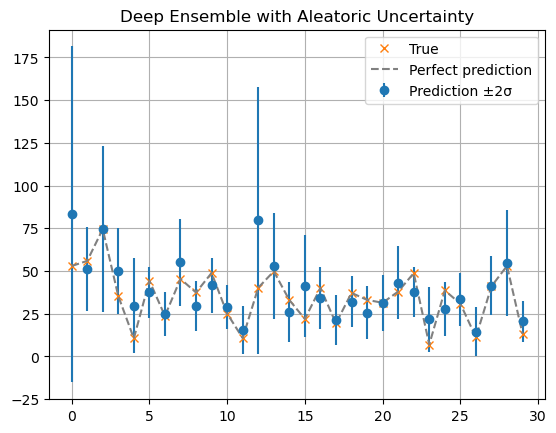

In [10]:
# Prediction Function
def predict_ensemble_aleatoric(models, X):

    mus, vars_ = [], []

    for model in models:
        model.eval()
        with torch.no_grad():
            mu, log_var = model(X)
            mus.append(mu.cpu().numpy())
            vars_.append(torch.exp(log_var).cpu().numpy())

    mus = np.stack(mus, axis=0)
    vars_ = np.stack(vars_, axis=0)
    mu_mean = mus.mean(axis=0)
    epistemic_var = mus.var(axis=0)
    aleatoric_var = vars_.mean(axis=0)
    total_std = np.sqrt(epistemic_var + aleatoric_var)
    return mu_mean.squeeze(), total_std.squeeze()



# Evaluation Metrics
def compute_picp_mpiw(pred_mean, pred_std, y_true, alpha=0.05):

    z = 1.96  # 95% confidence
    lower = pred_mean - z * pred_std
    upper = pred_mean + z * pred_std
    picp = np.mean((y_true >= lower) & (y_true <= upper))
    mpiw = np.mean(upper - lower)
    return picp, mpiw

# Predict
mu_pred, total_std = predict_ensemble_aleatoric(models, X_test_tensor)
picp, mpiw = compute_picp_mpiw(mu_pred.flatten(), total_std.flatten(), y_test)

# Log evaluation
writer.add_scalar("Evaluation/PICP_95", picp, 0)
writer.add_scalar("Evaluation/MPIW", mpiw, 0)

# Plot
plt.errorbar(range(30), mu_pred[:30], yerr=2*total_std[:30], fmt='o', label='Prediction ±2σ')
plt.plot(range(30), y_test[:30], 'x', label='True')
plt.plot(range(30), y_test[:30], label='Perfect prediction', linestyle='--', color='gray')
plt.title("Deep Ensemble with Aleatoric Uncertainty")
plt.legend()
plt.grid()
plt.savefig("ensemble_uncertainty_plot.png")
plt.show()

writer.close()
